# TP: Support Vector Machine (SVM)

*Authors: Quentin RAYNAUD & Benjamin TERNOT*

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.svm import SVC
from sklearn.datasets import make_blobs, make_circles
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate, train_test_split, GridSearchCV
from scipy.stats import multivariate_normal
from sklearn.metrics import confusion_matrix, classification_report
import itertools
from scipy.stats import multivariate_normal
from tqdm.notebook import tqdm

import datetime
from time import time


import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
plt.style.use('ggplot')

## Preliminary questions

**1)** Show that the primal problem solved by the SVM can be rewritten as follows :

$$ \text{argmin}_{\mathbf{w} \in \mathcal{H}, w_0 \in \mathbb{R} } \left( \frac{1}{2}||\mathbf{w}||^2 + C \sum_{i=1}^n [ 1 - y_i ( \langle \mathbf{w}, \Phi(\mathbf{x_i}) \rangle + w_0 )]_+ \right) $$

<div class='alert alert-block alert-warning'>
            Answer:</div>

\begin{equation}
\begin{aligned}
& \underset{w,b,\xi}{\text{minimize}}
& & \frac{1}{2} ||w||^2 + C \sum_{i=1}^{n} \xi_i \
& \text{subject to}
& & y_i(\langle \mathbf{w}, \Phi(\mathbf{x_i}) \rangle + w_0) \geq 1 - \xi_i, \ i = 1, \dots, n \
&&& \xi_i \geq 0, \ i = 1, \dots, n
\end{aligned}
\end{equation}

Therefore, $$\xi_i \geq 1 - y_i( \langle \mathbf{w}, \Phi(\mathbf{x_i}) \rangle + w_0)$$
$$\xi_i \geq 0, \ i = 1, \dots, n $$

So $$\xi_i \geq \text{max} (1 - y_i(\langle \mathbf{w}, \Phi(\mathbf{x_i}) \rangle + w_0),0) \ i = 1, \dots, n$$

We sum : $$\sum_{i=1}^n \xi_i \geq \sum_{i=1}^n \text{max} (1 - y_i(\langle \mathbf{w}, \Phi(\mathbf{x_i}) \rangle + w_0),0) $$

So $$  \frac{1}{2} ||w||^2 + C \sum_{i=1}^{n} \xi_i \geq \frac{1}{2} ||w||^2 + C \sum_{i=1}^n \text{max} (1 - y_i(\langle \mathbf{w}, \Phi(\mathbf{x_i}) \rangle + w_0),0) $$

If we take the minimum, solving the problem comes to $$ \text{argmin}_{\mathbf{w} \in \mathcal{H}, w_0 \in \mathbb{R} } \left( \frac{1}{2}||\mathbf{w}||^2 + C \sum_{i=1}^n [ 1 - y_i ( \langle \mathbf{w}, \Phi(\mathbf{x_i}) \rangle + w_0 )]_+ \right) $$

**2)** Explain the sentence : "an SVM minimizes the classification error using a convex upper bound". The function $x \rightarrow [1 - x]_+ = \text{max}(0, 1-x)$ is called *Hinge* (*charnière* en français). Explain the difference between the pivotal loss and the loss of binary classification.

<div class='alert alert-block alert-warning'>
            Answer:</div>

The SVM achieves this by minimizing the classification error using a convex upper bound, which is based on the Hinge loss function, as we see there is this loss in the previous demontration. The main difference between the pivotal loss and the loss of binary classification is that the pivotal loss is differentiable everywhere, which is better because we want the loss to be differentiable ( the second one isnt differentiable in 1).

## Example of using the SVC class from scikit-learn

In [2]:
#  Data Generation

def rand_gauss(n=100, mu=[1, 1], sigmas=[0.1, 0.1]):
    """ Sample n points from a Gaussian variable with center mu,
    and std deviation sigma
    """
    d = len(mu)
    res = np.random.randn(n, d)
    return np.array(res * sigmas + mu)


def rand_bi_gauss(n1=100, n2=100, mu1=[1, 1], mu2=[-1, -1], sigmas1=[0.1, 0.1],
                  sigmas2=[0.1, 0.1]):
    """ Sample n1 and n2 points from two Gaussian variables centered in mu1,
    mu2, with respective std deviations sigma1 and sigma2
    """
    ex1 = rand_gauss(n1, mu1, sigmas1)
    ex2 = rand_gauss(n2, mu2, sigmas2)
    y = np.hstack([np.ones(n1), -1 * np.ones(n2)])
    X = np.vstack([ex1, ex2])
    ind = np.random.permutation(n1 + n2)
    return X[ind, :], y[ind]

Training score : 0.95
Testing score : 0.95


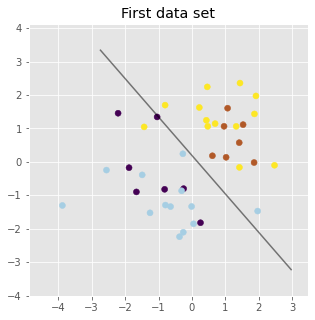

In [3]:
# This is an example of using SVC for data generated with the above function
n1 = 20
n2 = 20
mu1 = [1., 1.]
mu2 = [-1., -1.]
sigma1 = [0.9, 0.9]
sigma2 = [0.9, 0.9]
X1, y1 = rand_bi_gauss(n1, n2, mu1, mu2, sigma1, sigma2)

X_train = X1[::2]
Y_train = y1[::2].astype(int)
X_test = X1[1::2]
Y_test = y1[1::2].astype(int)

# fit the model with linear kernel
clf = SVC(kernel='linear')
clf.fit(X_train, Y_train)

# predict labels for the test data base
y_pred = clf.predict(X_test)

# check your score
score_train = clf.score(X_train, Y_train)
score_test = clf.score(X_test, Y_test)
print('Training score : %s' % score_train)
print('Testing score : %s' % score_test)

# display the points
plt.figure(1, figsize=(5, 5))
ax = plt.gca()
DecisionBoundaryDisplay.from_estimator(
    clf,
    X1,
    plot_method="contour",
    colors="k",
    levels=[0],
    alpha=0.5,
    ax=ax,
)
ax.scatter(X_train[:, 0], X_train[:, 1], c=Y_train)
ax.scatter(X_test[:, 0], X_test[:, 1], c=Y_test, cmap=plt.cm.Paired)
plt.title('First data set')
plt.axis('equal')
plt.show()

## Linear SVM

**3)** Draw a i.i.d. sample from a mixture of two Gaussian distributions : each class is a Gaussian with specific parameters. This time, use the function ```make_blobs``` available in ```sklearn.datasets``` library. Reserve 75% of the data for training and 25% for the test data.

<div class='alert alert-block alert-info'>
            Code:</div>

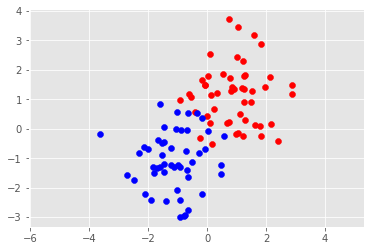

In [4]:
# Create two centers for the two distributions 
centers = np.array([[-1, -1], [1, 1]])

# Use make_blobs to generate the two dimensions points from the two centers
X, y = make_blobs(centers=centers, cluster_std=1, random_state=42)

# Plot the points 
pos = np.where(y == 1)[0]
neg = np.where(y == 0)[0]
plt.scatter(X[pos,0], X[pos,1], c='r')
plt.scatter(X[neg,0], X[neg,1], c='b')
plt.axis('equal')
plt.show()

In [5]:
# Use sklearn's train_test_split to divide up data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

**4)** Since the probability distributions are known, numerically estimate the Bayes risk. 

<div class='alert alert-block alert-info'>
            Code:</div>

In [6]:
# Do a Monte-Carlo estimation of the Bayes Risk (given the gaussian distributions you used to generate data)
# You need to use the imported class from scipy to generate a large number of samples which you will use 
# to approximate the integral of the Bayes risk
n_mc = int(1e4) # Repeat this n_mc times - enough to approximate 
expectation = 0
loss = np.array([[0, 1], [1, 0]])
for i in tqdm(range(n_mc)):
    rand = np.random.randint(0, 2)# Random binary choice: will the point be generated from the first or second gaussian ? 
    if not rand:
        # First case: y = 0
        x = np.random.multivariate_normal(centers[0], np.eye(2))
    else:
        # Second case: y = 1
        x = np.random.multivariate_normal(centers[1], np.eye(2))

    # You have to compute the conditional posterior probability of x given the 2 gaussians 
    # Use the multivariate_normal.pdf() method !    
    p1 = multivariate_normal.pdf(x, centers[0], 1)
    p2 = multivariate_normal.pdf(x, centers[1], 1)
    # Compute the risk from these and add it to the total
    risk = p1*loss[0, rand] + p2*loss[rand, 1]
    expectation += risk

expectation /= n_mc

print(f'Estimated Bayes risk: {expectation:.2%}')
print(f'Estimated Bayes accuracy: {1 - expectation:.2%}')

  0%|          | 0/10000 [00:00<?, ?it/s]

Estimated Bayes risk: 1.07%
Estimated Bayes accuracy: 98.93%


**5)** Draw the decision boundary $H$ induced by SVM as well as the hyperplanes $H_1$ and $H_{−1}$. Vary the parameter C to see its impact on the number of support vectors. We can use the code in the following example: https://scikit-learn.org/stable/auto_examples/svm/plot_separating_hyperplane.html.

<div class='alert alert-block alert-info'>
            Code:</div>

In [7]:
def format_duration(duration):
    td = datetime.timedelta(seconds=duration)
    hours, remainder = divmod(td.seconds, 3600)
    minutes, seconds = divmod(remainder, 60)
    microseconds = td.microseconds
    seconds += microseconds / 1000000

    parts = []
    if td.days > 0:
        parts.append(f'{td.days}d')
    if hours > 0:
        parts.append(f'{hours}h')
    if minutes > 0:
        parts.append(f'{minutes}min')
    if seconds > 1:
        parts.append(f'{seconds:.2f}s')
    elif not parts:
        parts.append(f'{microseconds/1000:.2f}ms')

    return ' '.join(parts)

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.1%' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="black" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', rotation=0, ha='right')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Fitting Linear SVM to training set...
Linear SVM : done in 4.00ms.
              precision    recall  f1-score   support

           0       0.93      1.00      0.96        13
           1       1.00      0.92      0.96        12

    accuracy                           0.96        25
   macro avg       0.96      0.96      0.96        25
weighted avg       0.96      0.96      0.96        25



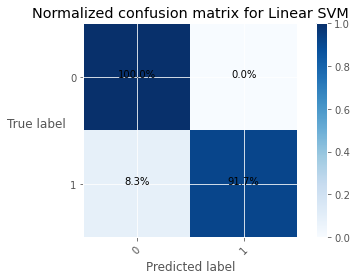

Train/Test scores: 94.67%/96.00%


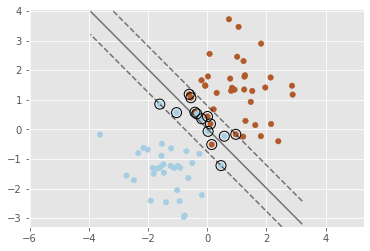

In [8]:
# Create a linear SVM and train it on the training data
clf = svm.SVC(kernel="linear")
t0 = time()
print("Fitting Linear SVM to training set...")
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(f"Linear SVM : done in {format_duration(time()-t0)}.")
print(classification_report(y_test, y_pred))

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=[0, 1], normalize=True,
                      title=f'Normalized confusion matrix for Linear SVM')
plt.show()
print(f'Train/Test scores: {clf.score(X_train, y_train):.2%}/{clf.score(X_test, y_test):.2%}')

# Plot the data
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=30, cmap=plt.cm.Paired)

# plot the decision function
ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()

# create grid to evaluate model
xx = np.linspace(xlim[0], xlim[1], 30)
yy = np.linspace(ylim[0], ylim[1], 30)
YY, XX = np.meshgrid(yy, xx)
xy = np.vstack([XX.ravel(), YY.ravel()]).T
Z = clf.decision_function(xy).reshape(XX.shape)

# plot decision boundary and margins
ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5,
           linestyles=['--', '-', '--'])
# plot support vectors
ax.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1], s=100,
           linewidth=1, facecolors='none', edgecolors='k')

plt.axis('equal')
plt.show()

**6)** Define the Gaussian classes such that the two distributions overlap. Draw an i.i.d. sample from the joint probability distribution. Apply a 5-fold Cross-Validation (for example, using the function ```GridSearchCV```) to find the optimal parameter $C∗$ to classify this new dataset using a linear kernel.

<div class='alert alert-block alert-info'>
            Code:</div>

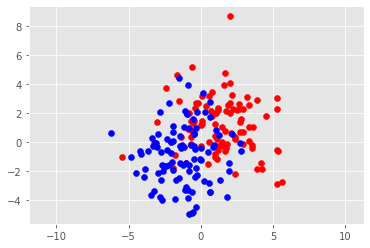

In [9]:
# Generate data and verify graphically that the two classes overlap
# Re-use the code from question 3 and 5
# Create two centers for the two distributions 
centers = np.array([[-1, -1], [1, 1]])

# Use make_blobs to generate the two dimensions points from the two centers
X, y = make_blobs(n_samples=200, centers=centers, cluster_std=2, random_state=42)

# Plot the points 
pos = np.where(y == 1)[0]
neg = np.where(y == 0)[0]
plt.scatter(X[pos,0], X[pos,1], c='r')
plt.scatter(X[neg,0], X[neg,1], c='b')
plt.axis('equal')
plt.show()

# Use sklearn's train_test_split to divide up data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

Grid search for LSVM parameters fitting on all data...
Grid search for LSVM done in 1.58s.
Best training params for LSVM: {'C': 0.001, 'kernel': 'linear'}

Fitting LSVM to train set...
Linear SVM : done in 8.01ms.
              precision    recall  f1-score   support

           0       0.71      0.80      0.75        25
           1       0.77      0.68      0.72        25

    accuracy                           0.74        50
   macro avg       0.74      0.74      0.74        50
weighted avg       0.74      0.74      0.74        50



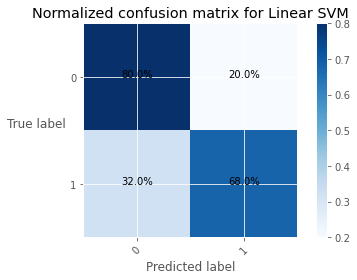

Train/Test scores: 82.67%/74.00%


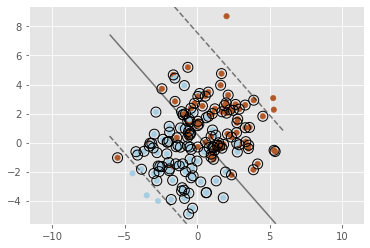

In [10]:
# Find the best working C with a 5-fold cross-validation
# Look into a bunch of values for C
parameters = {'kernel': ['linear'], 'C': list(np.logspace(-3, 3, 5))}
# Use these parameters + a SVM models with GridSearchCV (look at the documentation !)
clf = svm.SVC()
t0=time()
print(f'Grid search for LSVM parameters fitting on all data...')
grid_search = GridSearchCV(clf, parameters, cv=5, n_jobs=-1, scoring='accuracy')
grid_search.fit(X, y)
print(f'Grid search for LSVM done in {format_duration(time()-t0)}.')
print(f"Best training params for LSVM: {grid_search.best_params_}")

t0=time()
print("\nFitting LSVM to train set...")
clf = svm.SVC(**grid_search.best_params_)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(f"Linear SVM : done in {format_duration(time()-t0)}.")
print(classification_report(y_test, y_pred))

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=[0, 1], normalize=True,
                      title=f'Normalized confusion matrix for Linear SVM')
plt.show()
print(f'Train/Test scores: {clf.score(X_train, y_train):.2%}/{clf.score(X_test, y_test):.2%}')

# Plot the data
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=30, cmap=plt.cm.Paired)

# plot the decision function
ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()

# create grid to evaluate model
xx = np.linspace(xlim[0], xlim[1], 30)
yy = np.linspace(ylim[0], ylim[1], 30)
YY, XX = np.meshgrid(yy, xx)
xy = np.vstack([XX.ravel(), YY.ravel()]).T
Z = clf.decision_function(xy).reshape(XX.shape)

# plot decision boundary and margins
ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5,
           linestyles=['--', '-', '--'])
# plot support vectors
ax.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1], s=100,
           linewidth=1, facecolors='none', edgecolors='k')

plt.axis('equal')
plt.show()

**7)** Show how tuning SVM hyperparameters on training data, for example by taking a Gaussian kernel (the parameters are therefore $\gamma$ and $C$), can lead to overfitting.

<div class='alert alert-block alert-info'>
            Code:</div>

Grid search for SVM parameters fitting only on train data...
Grid search for LSVM done in 159.36ms.
Best training params for LSVM: {'C': 0.001, 'gamma': 0.1, 'kernel': 'rbf'}

Fitting SVM to train set...
Linear SVM : done in 12.00ms.
              precision    recall  f1-score   support

           0       0.70      0.76      0.73        25
           1       0.74      0.68      0.71        25

    accuracy                           0.72        50
   macro avg       0.72      0.72      0.72        50
weighted avg       0.72      0.72      0.72        50



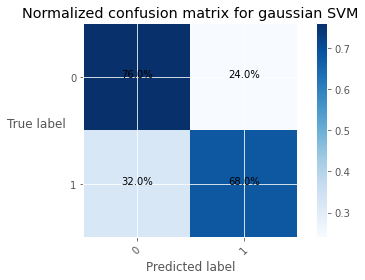

Train/Test scores: 84.67%/72.00%


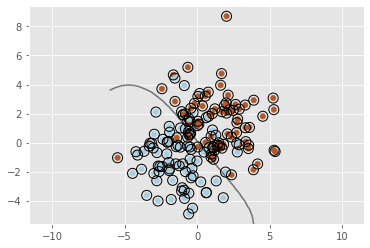

In [11]:
gammas = [0.1, 1, 10, 100]
# Create a gaussian svm and vary the parameter of the kernel, check the difference between training and testing scores
# Find the best working C with a 5-fold cross-validation
# Look into a bunch of values for C
parameters = {'kernel': ['rbf'], 'C': list(np.logspace(-3, 3, 5)), 'gamma':gammas}
# Use these parameters + a SVM models with GridSearchCV (look at the documentation !)
clf = svm.SVC()
t0=time()
print(f'Grid search for SVM parameters fitting only on train data...')
grid_search = GridSearchCV(clf, parameters, cv=5, n_jobs=-1, scoring='accuracy')
grid_search.fit(X_train, y_train)
print(f'Grid search for LSVM done in {format_duration(time()-t0)}.')
print(f"Best training params for LSVM: {grid_search.best_params_}")

t0=time()
print("\nFitting SVM to train set...")
clf = svm.SVC(**grid_search.best_params_)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(f"Linear SVM : done in {format_duration(time()-t0)}.")
print(classification_report(y_test, y_pred))

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=[0, 1], normalize=True,
                      title=f'Normalized confusion matrix for gaussian SVM')
plt.show()
print(f'Train/Test scores: {clf.score(X_train, y_train):.2%}/{clf.score(X_test, y_test):.2%}')

# Plot the data
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=30, cmap=plt.cm.Paired)

# plot the decision function
ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()

# create grid to evaluate model
xx = np.linspace(xlim[0], xlim[1], 30)
yy = np.linspace(ylim[0], ylim[1], 30)
YY, XX = np.meshgrid(yy, xx)
xy = np.vstack([XX.ravel(), YY.ravel()]).T
Z = clf.decision_function(xy).reshape(XX.shape)

# plot decision boundary and margins
ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5,
           linestyles=['--', '-', '--'])
# plot support vectors
ax.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1], s=100,
           linewidth=1, facecolors='none', edgecolors='k')

plt.axis('equal')
plt.show()

## Non linear SVM

**8)** Define a new binary nonlinear classification problem : for instance, define one class as a Gaussian surrounded by the other chosen as a circle class, or choose the second class as a mixture of two Gaussian in such way that the separation problem is nonlinear. Generate a non-linearly separable dataset (we could for example use the function ```make_blobs``` available in ```sklearn.datasetslibrary``` ).

<div class='alert alert-block alert-info'>
            Code:</div>

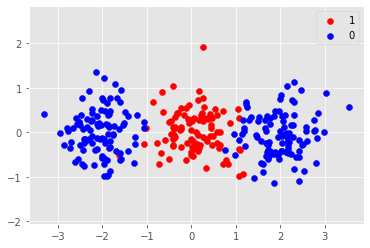

In [12]:
# Use make blobs with three centers which are aligned, for example
# Class 0 - Class 1 - Class 0 

# Create three centers for the two distributions 
centers = np.array([[-2, 0], [0, 0], [2, 0]])

# Use make_blobs to generate the two dimensions points from the three centers
X, y = make_blobs(n_samples=300, centers=centers, cluster_std=0.5, random_state=42)
y %= 2

# Plot the points 
pos = np.where(y == 1)[0]
neg = np.where(y == 0)[0]
plt.scatter(X[pos,0], X[pos,1], c='r', label='1')
plt.scatter(X[neg,0], X[neg,1], c='b', label='0')
plt.axis('equal')
plt.legend()
plt.show()

# Use sklearn's train_test_split to divide up data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)


**9)** Use an SVM with a linear kernel then a Gaussian (with well-adapted parameters, that you can obtain using, again, ```GridSearchCV```) then plot the decision boundaries of these algorithms on separate graphs.

<div class='alert alert-block alert-info'>
            Code:</div>

Grid search for Linear SVM parameters fitting on all data...
Grid search for Linear SVM done in 19.64s.
Best training params for Linear SVM: {'C': 0.001, 'kernel': 'linear'}

Fitting Linear SVM to train set...
Linear SVM : done in 8.59ms.
              precision    recall  f1-score   support

           0       0.67      1.00      0.80        50
           1       0.00      0.00      0.00        25

    accuracy                           0.67        75
   macro avg       0.33      0.50      0.40        75
weighted avg       0.44      0.67      0.53        75



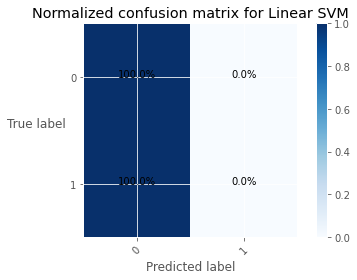

Train/Test scores: 66.67%/66.67%


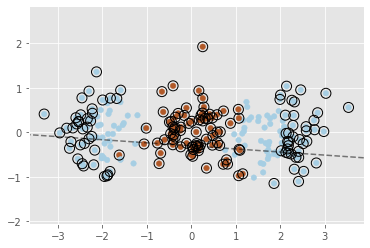


Grid search for Gaussian SVM parameters fitting on all data...
Grid search for Gaussian SVM done in 357.80ms.
Best training params for Gaussian SVM: {'C': 31.622776601683793, 'gamma': 10, 'kernel': 'rbf'}

Fitting Gaussian SVM to train set...
Gaussian SVM : done in 12.11ms.
              precision    recall  f1-score   support

           0       1.00      0.94      0.97        50
           1       0.89      1.00      0.94        25

    accuracy                           0.96        75
   macro avg       0.95      0.97      0.96        75
weighted avg       0.96      0.96      0.96        75



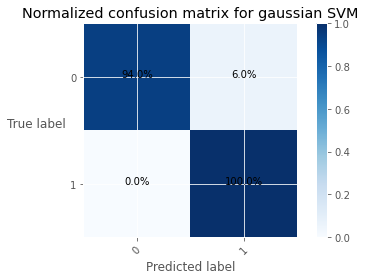

Train/Test scores: 100.00%/96.00%


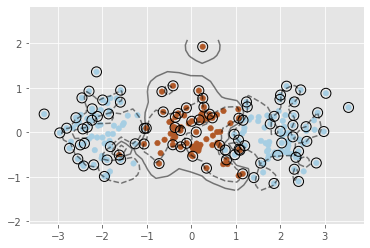

In [13]:
# Use the code of question 6 again
# Create a linear svm and vary the parameter of the kernel, check the difference between training and testing scores
# Find the best working C with a 5-fold cross-validation
# Look into a bunch of values for C
parameters = {'kernel': ['linear'], 'C': list(np.logspace(-3, 3, 5))}
# Use these parameters + a SVM models with GridSearchCV (look at the documentation !)
clf = svm.SVC()
t0=time()
print(f'Grid search for Linear SVM parameters fitting on all data...')
grid_search = GridSearchCV(clf, parameters, cv=5, n_jobs=-1, scoring='accuracy')
grid_search.fit(X, y)
print(f'Grid search for Linear SVM done in {format_duration(time()-t0)}.')
print(f"Best training params for Linear SVM: {grid_search.best_params_}")

t0=time()
print("\nFitting Linear SVM to train set...")
clf = svm.SVC(**grid_search.best_params_)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(f"Linear SVM : done in {format_duration(time()-t0)}.")
print(classification_report(y_test, y_pred))

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=[0, 1], normalize=True,
                      title=f'Normalized confusion matrix for Linear SVM')
plt.show()
print(f'Train/Test scores: {clf.score(X_train, y_train):.2%}/{clf.score(X_test, y_test):.2%}')

# Plot the data
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=30, cmap=plt.cm.Paired)

# plot the decision function
ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()

# create grid to evaluate model
xx = np.linspace(xlim[0], xlim[1], 30)
yy = np.linspace(ylim[0], ylim[1], 30)
YY, XX = np.meshgrid(yy, xx)
xy = np.vstack([XX.ravel(), YY.ravel()]).T
Z = clf.decision_function(xy).reshape(XX.shape)

# plot decision boundary and margins
ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5,
           linestyles=['--', '-', '--'])
# plot support vectors
ax.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1], s=100,
           linewidth=1, facecolors='none', edgecolors='k')

plt.axis('equal')
plt.show()


##Gaussian SVM
# Use the code of question 6 again
gammas = [0.1, 1, 10, 100]
# Create a gaussian svm and vary the parameter of the kernel, check the difference between training and testing scores
# Find the best working C with a 5-fold cross-validation
# Look into a bunch of values for C
parameters = {'kernel': ['rbf'], 'C': list(np.logspace(-3, 3, 5)), 'gamma':gammas}
# Use these parameters + a SVM models with GridSearchCV (look at the documentation !)
clf = svm.SVC()
t0=time()
print(f'\nGrid search for Gaussian SVM parameters fitting on all data...')
grid_search = GridSearchCV(clf, parameters, cv=5, n_jobs=-1, scoring='accuracy')
grid_search.fit(X, y)
print(f'Grid search for Gaussian SVM done in {format_duration(time()-t0)}.')
print(f"Best training params for Gaussian SVM: {grid_search.best_params_}")

t0=time()
print("\nFitting Gaussian SVM to train set...")
clf = svm.SVC(**grid_search.best_params_)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(f"Gaussian SVM : done in {format_duration(time()-t0)}.")
print(classification_report(y_test, y_pred))

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=[0, 1], normalize=True,
                      title=f'Normalized confusion matrix for gaussian SVM')
plt.show()
print(f'Train/Test scores: {clf.score(X_train, y_train):.2%}/{clf.score(X_test, y_test):.2%}')

# Plot the data
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=30, cmap=plt.cm.Paired)

# plot the decision function
ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()

# create grid to evaluate model
xx = np.linspace(xlim[0], xlim[1], 30)
yy = np.linspace(ylim[0], ylim[1], 30)
YY, XX = np.meshgrid(yy, xx)
xy = np.vstack([XX.ravel(), YY.ravel()]).T
Z = clf.decision_function(xy).reshape(XX.shape)

# plot decision boundary and margins
ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5,
           linestyles=['--', '-', '--'])
# plot support vectors
ax.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1], s=100,
           linewidth=1, facecolors='none', edgecolors='k')

plt.axis('equal')
plt.show()

## Learning curve

**10)** Draw the learning curve of the algorithm : with fixed hyper-parameters and a fixed test set, calculate the training and test errors by using training sub-sets of training data of various sizes (drawn randomly). For each size, repeat the experiment a large number of times to average the performance. 
Plot the train and test error based on the size of the train set subset. Estimate and display the accuracy of the Bayes predictor on the same graph. Comment.

<div class='alert alert-block alert-info'>
            Code:</div>

  0%|          | 0/41 [00:00<?, ?it/s]

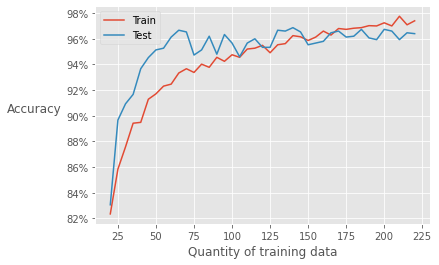

In [14]:
# Total number of training samples
n_tr = len(X_train)

# Repeat the experiment for all these training sizes
sizes = np.arange(20, n_tr, 5)

# Repeat each experiment this many times 
n_m = 20  

# Store scores in these lists
scores_train = []
scores_test = []

# Main loop: varying the training size
for size in tqdm(sizes):
    score_train = 0
    score_test = 0
    # Second loop: repeating the experiment for each size
    for i in range(n_m):
        # Create a SVM, keeping the same parameters
        clf = svm.SVC(**{'C': 31.622776601683793, 'gamma': 10, 'kernel': 'rbf'})
        # For each experiment, draw a subset of the training data of the appropriate size
        idx = np.random.choice(range(n_tr), size=size)
        X_train_reduced = X_train[idx, :]
        y_train_reduced = y_train[idx]
        
        # Fit the classifier and compute the scores on training and test data
        clf.fit(X_train_reduced, y_train_reduced)
        score_train += clf.score(X_train, y_train)
        score_test += clf.score(X_test, y_test)
    # Add the average of the scores to the lists
    scores_train.append(score_train/n_m)
    scores_test.append(score_test/n_m)
    
# Plot the results
plt.plot(sizes, scores_train, label='Train')
plt.plot(sizes, scores_test, label='Test')
plt.xlabel('Quantity of training data')
plt.ylabel('Accuracy', rotation=0, ha='right')
plt.gca().set_yticklabels([f'{val:,.0%}' for val in plt.gca().get_yticks()])

plt.legend()
plt.show()

In [15]:
# Do a Monte-Carlo estimation of the Bayes Risk (given the gaussian distributions you used to generate data)
# This is the same computation than in question 4). 

n_mc = int(1e4) # Repeat this n_mc times - enough to approximate 
expectation = 0
loss = np.array([[0, 1], [1, 0]])
for i in tqdm(range(n_mc)):
    rand = np.random.randint(0, 3)# Random choice: will the point be generated from the first second or third gaussian ? 
    x = np.random.multivariate_normal(centers[rand], np.eye(2)/2)

    # You have to compute the conditional posterior probability of x given the 3 gaussians 
    # Use the multivariate_normal.pdf() method !    
    p1 = multivariate_normal.pdf(x, centers[0], 0.5) + multivariate_normal.pdf(x, centers[2], 0.5)
    p2 = multivariate_normal.pdf(x, centers[1], 0.5)
    # Compute the risk from these and add it to the total
    risk = p1*loss[0, rand%2] + p2*loss[rand%2, 1]
    expectation += risk

expectation /= n_mc

print(f'Estimated Bayes risk: {expectation:.2%}')
print(f'Estimated Bayes accuracy: {1 - expectation:.2%}')

  0%|          | 0/10000 [00:00<?, ?it/s]

Estimated Bayes risk: 2.85%
Estimated Bayes accuracy: 97.15%


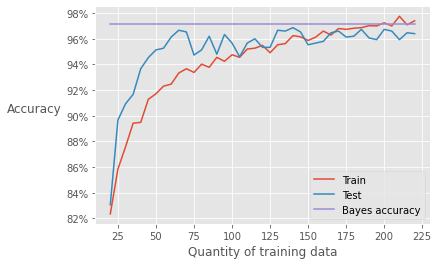

In [16]:
# Add this estimation to the plot of train/test error
# This is constant: you should add a horizontal line to your graph
# Plot the results
plt.plot(sizes, scores_train, label='Train')
plt.plot(sizes, scores_test, label='Test')
plt.plot(sizes, [1 - expectation]*sizes.size, label='Bayes accuracy')
plt.xlabel('Quantity of training data')
plt.ylabel('Accuracy', rotation=0, ha='right')
plt.gca().set_yticklabels([f'{val:,.0%}' for val in plt.gca().get_yticks()])


plt.legend()
plt.show()

<div class='alert alert-block alert-warning'>
            Answer:</div>
            


With Bayes estimation, the accuracy is even better than using all the data. We note that accuracy increases when we have more data used for training, but it is bounded by the value we found in the previous estimation with all data.

## Error versus complexity

**11)** Add noise to the dataset by randomly modifying the labels of some training data. Then, draw the complexity curves of the algorithm : with set train and test set, draw the train and test error as a function of the complexity (i.e. as a function of the value of the hyper-parameter controlling the complexity, or the number of support vector). Comment.

<div class='alert alert-block alert-info'>
            Code:</div>

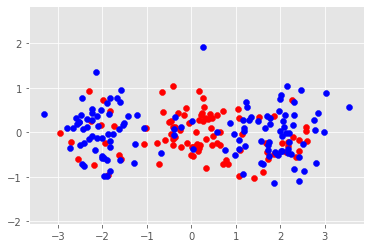

In [17]:
# Modify the class of some data points randomly
n_noise = 50
n_tr = len(y_train)
idx = np.random.choice(range(n_tr), n_noise)
y_train[idx] = 1 - y_train[idx]

pos = np.where(y_train == 1)[0]
neg = np.where(y_train == 0)[0]

# Visualise the data
plt.scatter(X_train[pos,0], X_train[pos,1], c='r')
plt.scatter(X_train[neg,0], X_train[neg,1], c='b')
plt.axis('equal')
plt.show()

  0%|          | 0/100 [00:00<?, ?it/s]

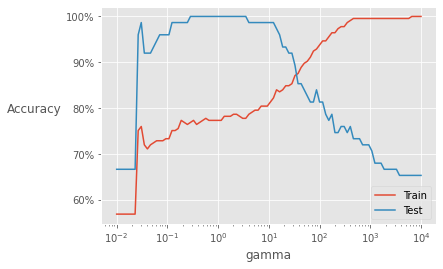

  0%|          | 0/100 [00:00<?, ?it/s]

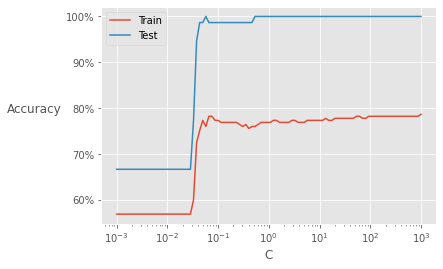

In [18]:
# Vary the appropriate parameter and plot the training/testing results
scores_train = []
scores_test = []

gammas = list(np.logspace(-2, 4, 100))

for i in tqdm(range(len(gammas))):
    clf = svm.SVC(kernel='rbf', gamma=gammas[i])
    clf.fit(X_train, y_train)
    scores_train.append(clf.score(X_train, y_train))
    scores_test.append(clf.score(X_test, y_test))

# Plot the results
plt.plot(gammas, scores_train, label='Train')
plt.plot(gammas, scores_test, label='Test')
plt.xlabel('gamma')
plt.xscale('log')
plt.ylabel('Accuracy', rotation=0, ha='right')
plt.gca().set_yticklabels([f'{val:,.0%}' for val in plt.gca().get_yticks()])

plt.legend()
plt.show()

# Vary the appropriate parameter and plot the training/testing results
scores_train = []
scores_test = []

c_params = list(np.logspace(-3, 3, 100))

for i in tqdm(range(len(gammas))):
    clf = svm.SVC(kernel='rbf', C=c_params[i])
    clf.fit(X_train, y_train)
    scores_train.append(clf.score(X_train, y_train))
    scores_test.append(clf.score(X_test, y_test))

# Plot the results
plt.plot(c_params, scores_train, label='Train')
plt.plot(c_params, scores_test, label='Test')
plt.xlabel('C')
plt.xscale('log')
plt.ylabel('Accuracy', rotation=0, ha='right')
plt.gca().set_yticklabels([f'{val:,.0%}' for val in plt.gca().get_yticks()])


plt.legend()
plt.show()

<div class='alert alert-block alert-warning'>
            Answer:</div>

It appears that the `gamma` parameter is responsible of an overfitting if we increase it to much, due to the precision over the train set it gives. On the other side, `C` parameter is a regularization parameter and increasing it helps keeping an high accuracy on unseen data. 

## Bonus : Application to face classification

Code for downloading and organizing the data:

In [19]:
###############################################################################
#               Face Recognition Task
###############################################################################
"""
The dataset used in this example is a preprocessed excerpt
of the "Labeled Faces in the Wild", aka LFW_:

  http://vis-www.cs.umass.edu/lfw/lfw-funneled.tgz (233MB)

  _LFW: http://vis-www.cs.umass.edu/lfw/

"""

from time import time
import pylab as pl
from sklearn.datasets import fetch_lfw_people


####################################################################
# Download the data (if not already on disk); load it as numpy arrays
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4,
                              color=True, funneled=False, slice_=None,
                              download_if_missing=True)
# data_home='.'

# introspect the images arrays to find the shapes (for plotting)
images = lfw_people.images
n_samples, h, w, n_colors = images.shape

# the label to predict is the id of the person
target_names = lfw_people.target_names.tolist()

####################################################################
# Pick a pair to classify such as
names = ['Tony Blair', 'Colin Powell']
# names = ['Donald Rumsfeld', 'Colin Powell']

idx0 = (lfw_people.target == target_names.index(names[0]))
idx1 = (lfw_people.target == target_names.index(names[1]))
images = np.r_[images[idx0], images[idx1]]
n_samples = images.shape[0]
y = np.r_[np.zeros(np.sum(idx0)), np.ones(np.sum(idx1))].astype(np.int)

####################################################################
# Extract features

# features using only illuminations
X = (np.mean(images, axis=3)).reshape(n_samples, -1)

# # or compute features using colors (3 times more features)
# X = images.copy().reshape(n_samples, -1)

# Scale features
X -= np.mean(X, axis=0)
X /= np.std(X, axis=0)

####################################################################
# Split data into a half training and half test set
# X_train, X_test, y_train, y_test, images_train, images_test = \
#    train_test_split(X, y, images, test_size=0.5, random_state=0)
# X_train, X_test, y_train, y_test = \
#    train_test_split(X, y, test_size=0.5, random_state=0)

indices = np.random.permutation(X.shape[0])
train_idx, test_idx = indices[:int(X.shape[0] / 2)], indices[int(X.shape[0] / 2):]
X_train, X_test = X[train_idx, :], X[test_idx, :]
y_train, y_test = y[train_idx], y[test_idx]
images_train, images_test = images[train_idx, :, :, :], images[test_idx, :, :, :]

**12)** By modifying the followind code, show the influence of the regularization parameter. For example, the prediction error can be displayed as a function of $C$ on a logarithmic scale between $1e5$ and $1e-5$.

<div class='alert alert-block alert-info'>
            Code:</div>

In [20]:
####################################################################
# Quantitative evaluation of the model quality on the test set
print("Fitting the classifier to the training set")
t0 = time()

# Add the regularization parameter and test for a range of values
# Plot the performances
clf = svm.SVC(kernel="linear")
clf.fit(X_train, y_train)
score = clf.score(X_test, y_test)

Fitting the classifier to the training set


In [ ]:
print("Predicting the people names on the testing set")
t0 = time()

# Predict labels for the X_test images with the best regularization parameter you obtained
y_pred = clf.predict(X_test)

print("done in %0.3fs" % (time() - t0))
print("Chance level : %s" % max(np.mean(y), 1. - np.mean(y)))
print("Accuracy : %s" % clf.score(X_test, y_test))

In [ ]:
####################################################################
# Qualitative evaluation of the predictions using matplotlib

def plot_gallery(images, titles, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    pl.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    pl.subplots_adjust(bottom=0, left=.01, right=.99, top=.90,
                       hspace=.35)
    for i in range(n_row * n_col):
        pl.subplot(n_row, n_col, i + 1)
        pl.imshow(images[i])
        pl.title(titles[i], size=12)
        pl.xticks(())
        pl.yticks(())


def title(y_pred, y_test, names):
    pred_name = names[int(y_pred)].rsplit(' ', 1)[-1]
    true_name = names[int(y_test)].rsplit(' ', 1)[-1]
    return 'predicted: %s\ntrue:      %s' % (pred_name, true_name)

# This will just show some examples with their associated prediction - nothing to change
prediction_titles = [title(y_pred[i], y_test[i], names)
                     for i in range(y_pred.shape[0])]

plot_gallery(images_test, prediction_titles)
pl.show()

**13)** By adding nuisance variables, thus increasing the number of variables to the number of learning
points fixed, show that performance drops.

<div class='alert alert-block alert-info'>
            Code:</div>

In [ ]:
# Add a number of nuisance variable to the existing data points, by generating randomly their values


**14)** What is the effect of choosing a non-linear RBF kernel on prediction ? You will be able to improve the prediction with a reduction of dimension based on the object ```sklearn.decomposition.RandomizedPCA```.

<div class='alert alert-block alert-info'>
            Code:</div>

In [ ]:
# Apply the SVM with the chosen kernel after dimension reduction by PCA
